<a href="https://colab.research.google.com/github/sayan0506/Tensorflow-in-practice-specialization/blob/master/SUNSPOT_time_series_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# this is used to visualize the time series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
# downloading the dataset frfom kaggle
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-12-30 20:05:51--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-12-30 20:05:51 (96.8 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



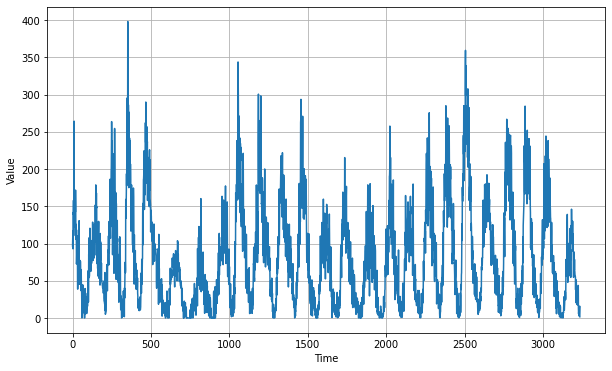

In [ ]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

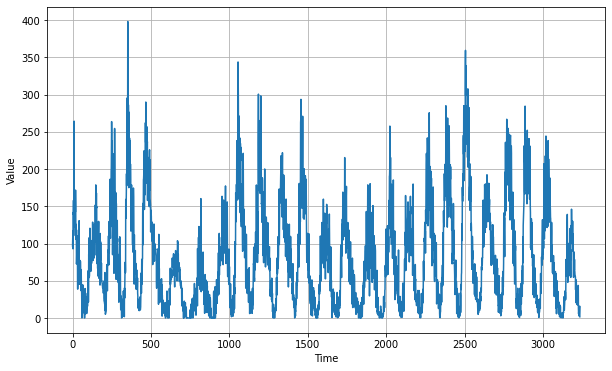

In [ ]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-8)
                                     #, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 3s 25ms/step - loss: 77.1865 - mae: 77.6835
Epoch 2/100
12/12 [==============================] - 0s 31ms/step - loss: 77.3998 - mae: 77.8968
Epoch 3/100
12/12 [==============================] - 0s 30ms/step - loss: 77.8598 - mae: 78.3565
Epoch 4/100
12/12 [==============================] - 1s 43ms/step - loss: 77.0399 - mae: 77.5368
Epoch 5/100
12/12 [==============================] - 0s 31ms/step - loss: 76.6472 - mae: 77.1440
Epoch 6/100
12/12 [==============================] - 1s 43ms/step - loss: 76.9996 - mae: 77.4964
Epoch 7/100
12/12 [==============================] - 1s 34ms/step - loss: 77.5024 - mae: 77.9991
Epoch 8/100
12/12 [==============================] - 0s 32ms/step - loss: 77.1539 - mae: 77.6506
Epoch 9/100
12/12 [==============================] - 0s 30ms/step - loss: 76.9033 - mae: 77.4001
Epoch 10/100
12/12 [=====

(1e-08, 0.0001, 0.0, 60.0)

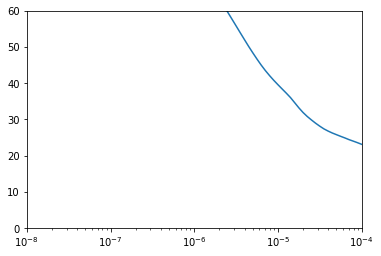

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.Adam(lr=1e-4)
                                     #, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 4s 17ms/step - loss: 107.9651 - mae: 108.4621
Epoch 2/500
30/30 [==============================] - 1s 15ms/step - loss: 77.4177 - mae: 77.9147
Epoch 3/500
30/30 [==============================] - 1s 15ms/step - loss: 67.5230 - mae: 68.0201
Epoch 4/500
30/30 [==============================] - 1s 17ms/step - loss: 43.5556 - mae: 44.0525
Epoch 5/500
30/30 [==============================] - 1s 16ms/step - loss: 31.1297 - mae: 31.6246
Epoch 6/500
30/30 [==============================] - 1s 16ms/step - loss: 26.2920 - mae: 26.7866
Epoch 7/500
30/30 [==============================] - 1s 17ms/step - loss: 23.4957 - mae: 23.9884
Epoch 8/500
30/30 [==============================] - 1s 16ms/step - loss: 22.1269 - mae: 22.6192
Epoch 9/500
30/30 [==============================] - 1s 17ms/step - loss: 21.6029 - mae: 22.0955
Epoch 10/500
30/30 [==============================] - 1s 17ms/step - loss: 21.3008 - mae: 21.7936
Epoch 11/500
30/30 [=======

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

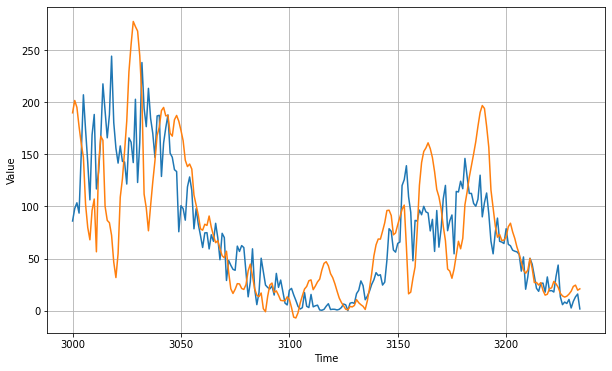

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

32.94157

<Figure size 432x288 with 0 Axes>

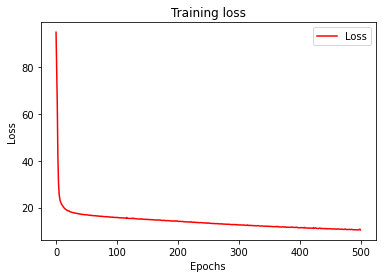

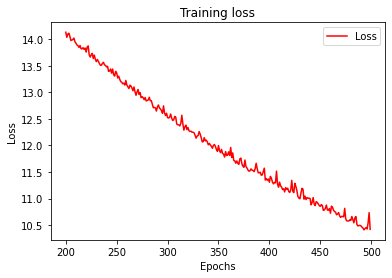

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast)

[189.90692   201.73523   195.16821   176.61748   160.45683   147.23537
 102.007065   79.80938    67.96037    96.14046   107.1042     56.443424
 140.00542   167.42197   163.5265    100.092064   86.57879    84.34755
  72.24117    46.461315   31.693014   54.758896  108.89174   126.53118
 153.26154   182.04703   229.25465   255.48688   277.61264   272.68134
 268.3986    244.71411   204.49837   111.864975   98.44899    76.619255
 100.75364   123.520996  143.70494   167.98491   176.23007   192.04411
 195.05496   186.9491    187.4377    170.31226   167.49153   183.27884
 187.3695    181.8315    173.07738   163.14334   144.35623   138.26059
 140.70885   135.89186   110.95924   101.0393     91.621185   78.502594
  77.20649    82.89499    81.77284    90.80789    80.01983    72.046486
  65.17363    67.16391    59.344803   52.69022    50.688316   56.98074
  36.86218    20.86995    16.466322   20.465166   25.86309    25.598246
  21.237951   20.285225   24.947824   38.107975   44.585487   33.182056
